In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from matplotlib.lines import lineStyles
sns.set(context="notebook", style="ticks")
plt.rcParams.update({"font.sans-serif": "Fira Sans Condensed"})

In [41]:
guides = [
    # "ml",
    # "map",
    "laplace",
    "meanfield",
    "lowrank",
    "radial",
]
cols = [
    ("Guide", str),
    ("Number of parameters", int),
    ("Wall clock time", float),
    ("NLL", float),
    ("Accuracy", float),
    ("AUROC", float),
    ("Average confidence", float),
    ("Average confidence when wrong", float),
    ("Average confidence when right", float),
]
data = []
with open("/home/silas/Documents/university/special-course/results.txt", "r") as f:
    for guide in guides:
        row = [guide]
        for col, dt in cols[1:]:
            line = f.readline()
            val = dt(line.rstrip("\n").split(": ")[1])
            row.append(val)
        data.append(row)
results = pd.DataFrame(data, columns=[col for col, _ in cols])


In [42]:
results

,Guide,Number of parameters,Wall clock time,NLL,Accuracy,AUROC,Average confidence,Average confidence when wrong,Average confidence when right
0,laplace,26506,420.731901,0.145557,0.9592,0.998626,0.937530,0.635705,0.950368
1,meanfield,26506,470.480763,0.283930,0.9254,0.994368,0.869576,0.566543,0.894005
2,lowrank,26506,533.755054,0.322636,0.9166,0.993046,0.851530,0.567636,0.877361
3,radial,53012,568.390920,0.290499,0.9296,0.995331,0.845931,0.538169,0.869239


In [ ]:
import pickle

In [121]:
eval_dataset = "fashionmnist"
results = []
for guide in guides:
    with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        row = [
            data["Inference"],
            data["Trained on"],
            data["Wall clock time"],
            data[f"eval_{eval_dataset}"]["Number of parameters"],
            data[f"eval_{eval_dataset}"]["NLL"].item(),
            data[f"eval_{eval_dataset}"]["Accuracy"],
            data[f"eval_{eval_dataset}"]["AUROC"],
            data[f"eval_{eval_dataset}"]["Average confidence"],
            data[f"eval_{eval_dataset}"]["Average confidence when wrong"],
            data[f"eval_{eval_dataset}"]["Average confidence when right"],
        ]
        results.append(row)
results = pd.DataFrame(results, columns=["Inference", "Trained on", "Wall clock time", "Number of parameters", "NLL", "Accuracy", "AUROC", "Average confidence", "Average confidence when wrong", "Average confidence when right"])
results

,Inference,Trained on,Wall clock time,Number of parameters,NLL,Accuracy,AUROC,Average confidence,Average confidence when wrong,Average confidence when right
0,laplace,MNIST,2109.665755,26506,5.455306,0.0723,0.510022,0.758896,0.765111,0.679140
1,meanfield,MNIST,2369.328419,53012,3.823975,0.0587,0.431981,0.509793,0.516658,0.399713
2,lowrank,MNIST,2464.330157,318072,3.603083,0.0619,0.480265,0.583273,0.596431,0.383872
3,radial,MNIST,2309.447991,53012,4.015168,0.0628,0.495626,0.631410,0.638049,0.532339


In [155]:
def calibration_curves(y_true, y_prob, y_pred, bins=10):
    real_probs = []
    pred_probs = []
    # count, lims = np.histogram(true_probs, bins=bins)
    count, lims = np.histogram(true_probs, range=(0., 1.), bins=bins)
    for i in range(bins):
        lower, upper = lims[i], lims[i+1]
        mask = (lower <= y_prob) & (y_prob < upper)
        # Find targets for which our prediction lies within a range
        targets_in_range = y_true[mask]
        preds_in_range = y_pred[mask]
        n_in_range = y_true[mask].shape[0]
        range_acc = np.sum(targets_in_range == preds_in_range) / n_in_range

        real_probs.append(range_acc)
        pred_probs.append((lower+upper)/2)
    return real_probs, pred_probs

/tmp/ipykernel_22316/630468080.py:13: RuntimeWarning: invalid value encountered in long_scalars
  range_acc = np.sum(targets_in_range == preds_in_range) / n_in_range


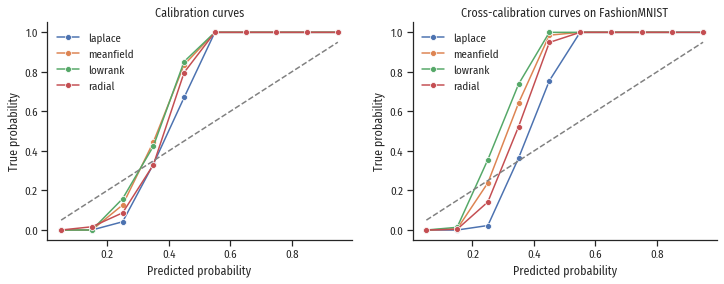

In [156]:
bins = 10

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
for i, (dataset, title) in enumerate([("mnist", "Calibration curves"), ("fashionmnist", "Cross-calibration curves on FashionMNIST")]):
    for guide in guides:
        with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
            data = pickle.load(f)

            targets = data[f"eval_{dataset}"]["Test targets"][:,None]
            probs = data[f"eval_{dataset}"]["Test probabilities"]

            preds = np.argmax(probs, axis=1)[:, None]
            true_probs = np.take_along_axis(probs, targets, axis=1)
            prob_true, prob_pred = calibration_curves(targets, true_probs, preds, bins=bins)

            sns.lineplot(x=prob_pred, y=prob_true, marker="o", label=guide, ax=ax[i])
            # ax.plot(prob_pred, prob_true, label=guide, marker="o")
    ax[i].plot(prob_pred, prob_pred, "--", color="grey")
    ax[i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
    )
    ax[i].legend(frameon=False)
sns.despine(fig)

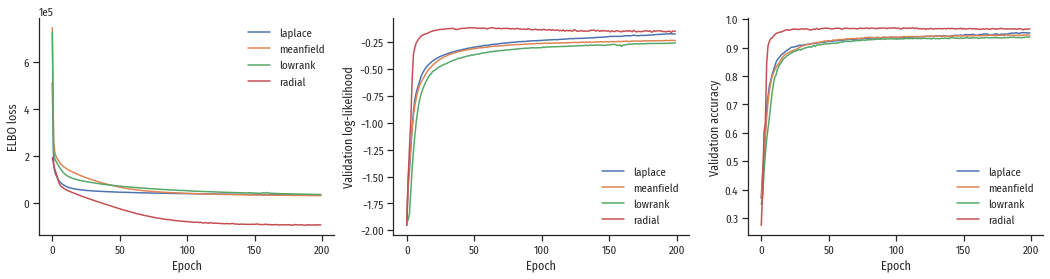

In [143]:
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
for guide in [
    "laplace",
    "meanfield",
    "lowrank",
    "radial",
]:
    with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        epochs = np.arange(len(data["Training ELBO"]))
        sns.lineplot(x=epochs, y=data["Training ELBO"], label=guide, ax=ax[0])
        sns.lineplot(x=epochs, y=np.array([val.numpy() for val in data["Validation log-likelihood"]]), label=guide, ax=ax[1])
        sns.lineplot(x=epochs, y=1-np.array([val.numpy() for val in data["Validation accuracy"]]), label=guide, ax=ax[2])
ax[0].set(
    xlabel="Epoch",
    ylabel="ELBO loss",
)
ax[1].set(
    xlabel="Epoch",
    ylabel="Validation log-likelihood",
)
ax[2].set(
    xlabel="Epoch",
    ylabel="Validation accuracy",
)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)
sns.despine(fig)